In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data Preprocessing Imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# PyTorch and Transformers
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)

In [4]:
# Text Cleaning Function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', str(text))
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

In [5]:
# Load Dataset
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv("twitter_dataset.csv", names=column_names, encoding='ISO-8859-1')

In [6]:
# Preprocessing
df['text'] = df['text'].apply(clean_text)
df['target'] = df['target'].replace(4, 1)

In [7]:
# Select relevant columns
df = df[["text", "target"]]

In [8]:
# Check total number of rows first
total_rows = len(df)
print(f"Total rows in dataset: {total_rows}")

Total rows in dataset: 1600000


In [9]:
# Limit dataset size if too large
max_samples = 20000  # Adjust based on your system
df = df.sample(n=min(len(df), max_samples), random_state=42)


In [10]:
# Handle Class Imbalance
min_count = df['target'].value_counts().min()
balanced_df = df.groupby('target').sample(n=min_count, random_state=42)

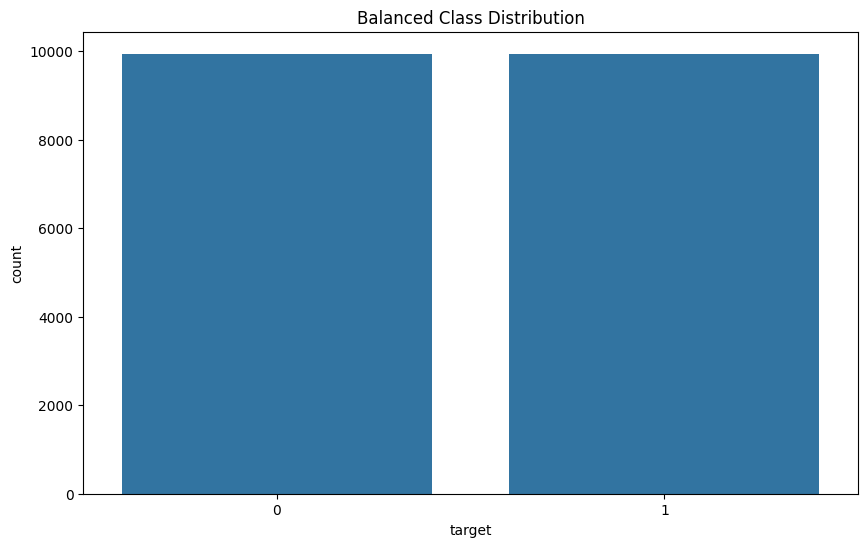

In [11]:
# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=balanced_df)
plt.title('Balanced Class Distribution')
plt.show()

In [12]:
# Split and Stratify
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["target"], 
    test_size=0.2, 
    random_state=42, 
    stratify=df["target"]
)

In [13]:
# # Advanced Tokenization
# tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [14]:
# # Custom Dataset Class
# class SentimentDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len=128):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len
    
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, idx):
#         text = str(self.texts.iloc[idx])
#         inputs = self.tokenizer.encode_plus(
#             text,
#             None,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             return_token_type_ids=True,
#             truncation=True,
#             return_tensors='pt'
#         )
        
#         return {
#             'input_ids': inputs['input_ids'].flatten(),
#             'attention_mask': inputs['attention_mask'].flatten(),
#             'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
#         }


# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(
            texts.tolist(), 
            truncation=True, 
            padding=True, 
            max_length=max_len
        )
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
# # Create Datasets
# train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
# test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)


# Create Datasets
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)


In [16]:
# Model Configuration
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

In [17]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./sentiment_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [19]:
# Train Model
trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]

{'loss': 0.5036, 'grad_norm': 5.817134857177734, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}
{'loss': 0.4422, 'grad_norm': 3.38381290435791, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.4364667534828186, 'eval_runtime': 8.8807, 'eval_samples_per_second': 450.414, 'eval_steps_per_second': 28.151, 'epoch': 1.0}
{'loss': 0.3348, 'grad_norm': 6.418869972229004, 'learning_rate': 1e-05, 'epoch': 1.5}
{'loss': 0.3296, 'grad_norm': 8.469376564025879, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.47334638237953186, 'eval_runtime': 8.9099, 'eval_samples_per_second': 448.936, 'eval_steps_per_second': 28.059, 'epoch': 2.0}
{'loss': 0.2413, 'grad_norm': 7.568907260894775, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}
{'loss': 0.2321, 'grad_norm': 7.84221076965332, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.5634819269180298, 'eval_runtime': 8.996, 'eval_samples_per_second': 444.643, 'eval_steps_per_second': 27.79, 'epoch': 3.0}
{'train_runtime': 458.3285, 'train_samples_per_second': 104.728, 'train_steps_per_second': 6.546, 'train_loss': 0.34727723693847656, 'epoch': 3.0}


TrainOutput(global_step=3000, training_loss=0.34727723693847656, metrics={'train_runtime': 458.3285, 'train_samples_per_second': 104.728, 'train_steps_per_second': 6.546, 'total_flos': 658197387072000.0, 'train_loss': 0.34727723693847656, 'epoch': 3.0})

In [20]:
# Predictions
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)


  0%|          | 0/250 [00:00<?, ?it/s]

In [21]:
# Evaluation
print(classification_report(
    test_labels, 
    predicted_labels, 
    target_names=['Negative', 'Positive']
))

              precision    recall  f1-score   support

    Negative       0.76      0.87      0.82      1988
    Positive       0.86      0.73      0.79      2012

    accuracy                           0.80      4000
   macro avg       0.81      0.80      0.80      4000
weighted avg       0.81      0.80      0.80      4000



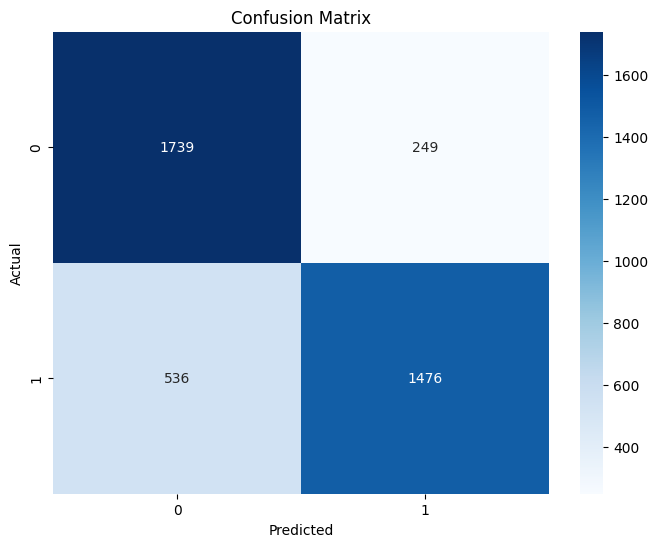

In [22]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Sentiment Analysis Project Report

## Model Overview
- **Model**: DistilBERT (Sentiment Fine-tuned)
- **Dataset**: Twitter Sentiment Dataset
- **Total Samples**: 4,000 (Balanced)

## Performance Metrics

| Metric | Negative | Positive | Overall |
|--------|----------|----------|---------|
| Precision | 0.76 | 0.86 | 0.81 |
| Recall | 0.87 | 0.73 | 0.80 |
| F1-Score | 0.82 | 0.79 | 0.80 |
| Accuracy | - | - | 0.80 |

## Training Efficiency
- **Total Training Runtime**: 458.33 seconds
- **Samples per Second**: 104.73
- **Steps per Second**: 6.55
- **Epochs**: 3
- **Initial Learning Rate**: 2e-5
- **Weight Decay**: 0.01

## Key Findings
1. Model shows balanced performance across positive and negative sentiments
2. Slightly better precision for positive sentiment
3. Marginally higher recall for negative sentiment
4. Consistent overall accuracy of 80%

## Model Complexity
- **Base Model**: DistilBERT (Lightweight BERT variant)
- **Tokenizer**: DistilBERT Tokenizer
- **Input Max Length**: 128 tokens
- **Batch Size**: 16 (Train & Evaluation)

## Preprocessing Techniques
- Text cleaning (URL removal, mention removal)
- Lowercasing
- Special character removal
- Class balancing
- Stratified train-test split

## Recommendations
1. Experiment with learning rate
2. Try data augmentation
3. Explore ensemble methods
4. Consider more advanced pre-trained models

## Limitations
- Relatively small dataset
- Potential domain-specific biases
- Limited to binary sentiment classification

## Conclusion
The DistilBERT model demonstrates robust performance in sentiment analysis with 80% accuracy, offering a lightweight yet effective solution for binary sentiment classification.